In [135]:
import os
import sys
import random
from datetime import datetime

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import destruction_utilities as utils
import destruction_models as models



In [155]:
TRAIN = 'aleppo'
TEST = 'aleppo'
MODEL_DIR = '../../models'
DATA_DIR = '../../data'
BATCH_SIZE = 64
PATCH_SIZE = (128,128)
FILTERS = [32]
DROPOUT = [0.3, 0.45]
EPOCHS = [70, 100]
UNITS = [64]
LR = [0.003, 0.003, 0.004]
VARIANT = "DIST" # NO_DIST, EXTRA_CONV

In [156]:
from tensorflow.keras import callbacks, metrics
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import time
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_score, recall_score

In [157]:
# Move this to destruction utilities
class SiameseGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32):
        self.images_t0 = images[0]
        self.images_tt = images[1]
        self.labels = labels
        self.batch_size = batch_size
        
        self.tuple_pairs = utils.make_tuple_pair(self.images_t0.shape[0], int(self.batch_size/4))
        np.random.shuffle(self.tuple_pairs)
   
    def __len__(self):
        return len(self.images_t0)//self.batch_size    
    
    def __getitem__(self, index):
        return self.get_sub_batch(index)

    def get_sub_batch(self,index):
        pos = index*4
        
        t, h, w, d = self.images_t0.shape
        X_t0_main = np.empty((0, h, w,d))
        X_tt_main = np.empty((0, h, w,d))
        y_main = np.empty(0)
#         X_t0_main = np.empty(0, h, w,d)
        for i in range(0,4):
            index_range = self.tuple_pairs[pos+i]
            X_t0 = self.images_t0[index_range[0]:index_range[1]]
            X_tt = self.images_tt[index_range[0]:index_range[1]]
            y = self.labels[index_range[0]:index_range[1]]
            
            X_t0_main=np.append(X_t0_main, X_t0, axis=0)
            X_tt_main=np.append(X_tt_main, X_tt, axis=0)
            y_main=np.append(y_main, y, axis=0)
            alpha = random.choice(np.linspace(0.9, 1.1))
            alpha = 1
            
        indices = np.arange(0,self.batch_size)
        np.random.shuffle(indices)

        return {'images_t0':X_t0_main[indices]/255.0, 'images_tt':X_tt_main[indices]/255.0}, y_main[indices]
        
    def augment(self, X):
#         # Horizontal and vertical flip
#         flipping_funcs = [
#             lambda image: image,
#             lambda image: np.fliplr(image),
#             lambda image: np.flipud(image),
#             lambda image: np.flipud(np.fliplr(image))
#         ]
#         func = random.choice(flipping_funcs)
#         X = func(X)
        
#         # Brightness
#         alpha = random.choice(np.linspace(0.85, 1.4))
# #         alpha = 1
#         X = X * alpha

        return X

In [158]:
train_images_t0 = read_zarr(TRAIN, 'images_siamese_train_t0')
train_images_tt = read_zarr(TRAIN, 'images_siamese_train_tt')
train_labels = read_zarr(TRAIN, 'labels_siamese_train')

valid_images_t0 = read_zarr(TRAIN, 'images_siamese_valid_t0')
valid_images_tt = read_zarr(TRAIN, 'images_siamese_valid_tt')
valid_labels = read_zarr(TRAIN, 'labels_siamese_valid')


test_images_t0 = read_zarr(TEST, 'images_siamese_test_t0')
test_images_tt = read_zarr(TEST, 'images_siamese_test_tt')
test_labels = read_zarr(TEST, 'labels_siamese_test')

In [164]:
train_gen = SiameseGenerator((train_images_t0, train_images_tt), train_labels, batch_size=BATCH_SIZE)
valid_gen = SiameseGenerator((valid_images_t0, valid_images_tt), valid_labels, batch_size=BATCH_SIZE)

In [175]:
if VARIANT == 'DIST':
    
    MODEL_STORAGE_LOCATION = f"{MODEL_DIR}/{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}"
    
    training_callbacks = [
        callbacks.EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{MODEL_STORAGE_LOCATION}', monitor='val_auc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
    ]
    
    print(f"Model will be stored at: {MODEL_STORAGE_LOCATION}")
    
    filters = random.choice(FILTERS)
    dropout = random.choice(np.linspace(*DROPOUT))
    epochs = random.choice(np.arange(*EPOCHS))
    units = random.choice(UNITS)
    lr = random.choice(LR)
    
    args  = dict(filters=filters, dropout=dropout, units=units)
    parameters = f'Model parameters: filters={filters}, \ndropout={np.round(dropout, 4)}, \nepochs={epochs}, \nunits={units}, \nlearning_rate={lr}'
    
    model = models.siamese_convolutional_network_dist(
        shape=(*PATCH_SIZE, 3),  
        args = args,
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_focal_crossentropy', metrics=['accuracy',metrics.AUC(num_thresholds=200, curve='ROC', name='auc')])
    

Model will be stored at: ../../models/16_11_2022_01_27_35


In [ ]:
if VARIANT == 'NO_DIST':
    
    MODEL_STORAGE_LOCATION = f"{MODEL_DIR}/{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}"
    
    training_callbacks = [
        callbacks.EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{MODEL_STORAGE_LOCATION}', monitor='val_auc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
    ]
    
    print(f"Model will be stored at: {MODEL_STORAGE_LOCATION}")
    
    filters = random.choice(FILTERS)
    dropout = random.choice(np.linspace(*DROPOUT))
    epochs = random.choice(np.arange(*EPOCHS))
    units = random.choice(UNITS)
    lr = random.choice(LR)
    
    args_encode  = dict(filters=filters, dropout=dropout) # ! Check parameters before run
    args_dense  = dict(units=units) # ! Check parameters before run

    parameters = f'filters={filters}, \ndropout={np.round(dropout, 4)}, \nepochs={epochs}, \nunits={units}, \nlearning_rate={lr}'
    print(parameters)
    
#     model = models.siamese_convolutional_network(shape=(*TILE_SIZE, 3), args_encode=args_encode, args_dense=args_dense)
    model = models.siamese_convolutional_network(shape=(*TILE_SIZE, 3),  args_encode=dict(filters=filters, dropout=dropout), args_dense=dict(units=units, dropout=dropout))
   
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',metrics.AUC(num_thresholds=200, curve='ROC', name='auc')])
    

In [173]:
model.summary()

Model: "siamese_convolutional_network_dist"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images_t0 (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 images_tt (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           (None, 64)           552928      ['images_t0[0][0]',              
                                                                 

In [174]:
# Train model on dataset
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    verbose=2,
    callbacks=training_callbacks
)
    

Epoch 1/81


2022-11-15 20:46:21.845508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-15 20:46:53.864335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ../../models/15_11_2022_20_46_16/assets
105/105 - 43s - loss: 0.1838 - accuracy: 0.8984 - auc: 0.6114 - val_loss: 0.1435 - val_accuracy: 0.6605 - val_auc: 0.6062 - 43s/epoch - 410ms/step
Epoch 2/81
105/105 - 32s - loss: 0.0958 - accuracy: 0.8984 - auc: 0.6866 - val_loss: 0.1301 - val_accuracy: 0.8830 - val_auc: 0.5370 - 32s/epoch - 302ms/step
Epoch 3/81
INFO:tensorflow:Assets written to: ../../models/15_11_2022_20_46_16/assets
105/105 - 39s - loss: 0.0905 - accuracy: 0.8984 - auc: 0.6757 - val_loss: 0.1090 - val_accuracy: 0.8830 - val_auc: 0.6403 - 39s/epoch - 370ms/step
Epoch 4/81


KeyboardInterrupt: 

In [ ]:
utils.display(train_gen.__getitem__(8)[0]['images_t0'][24].astype('int'))

In [148]:
train_gen.__getitem__(3)

({'images_t0': array([[[[132., 113., 107.],
           [140., 121., 115.],
           [148., 130., 123.],
           ...,
           [ 41.,  32.,  33.],
           [ 41.,  36.,  41.],
           [ 49.,  40.,  41.]],
  
          [[123., 109.,  99.],
           [132., 113., 107.],
           [132., 117., 107.],
           ...,
           [ 33.,  24.,  25.],
           [ 33.,  28.,  33.],
           [ 49.,  40.,  41.]],
  
          [[115.,  97.,  90.],
           [115., 105.,  90.],
           [123., 105.,  99.],
           ...,
           [ 25.,  20.,  16.],
           [ 25.,  20.,  25.],
           [ 49.,  45.,  41.]],
  
          ...,
  
          [[ 41.,  32.,  41.],
           [ 33.,  28.,  33.],
           [ 33.,  24.,  33.],
           ...,
           [ 41.,  40.,  41.],
           [ 49.,  40.,  49.],
           [ 49.,  40.,  41.]],
  
          [[ 33.,  32.,  33.],
           [ 33.,  28.,  33.],
           [ 33.,  24.,  25.],
           ...,
           [ 41.,  36.,  41.],
     

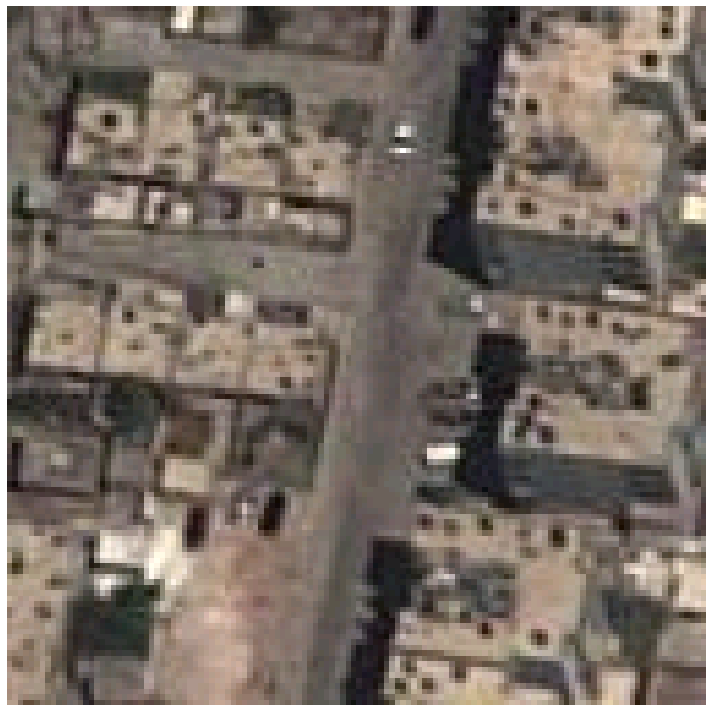

In [91]:
utils.display(train_images_t0[34].astype('int'))

In [56]:
train_images = read_zarr(TRAIN, 'images_conv_train', path=DATA_DIR)


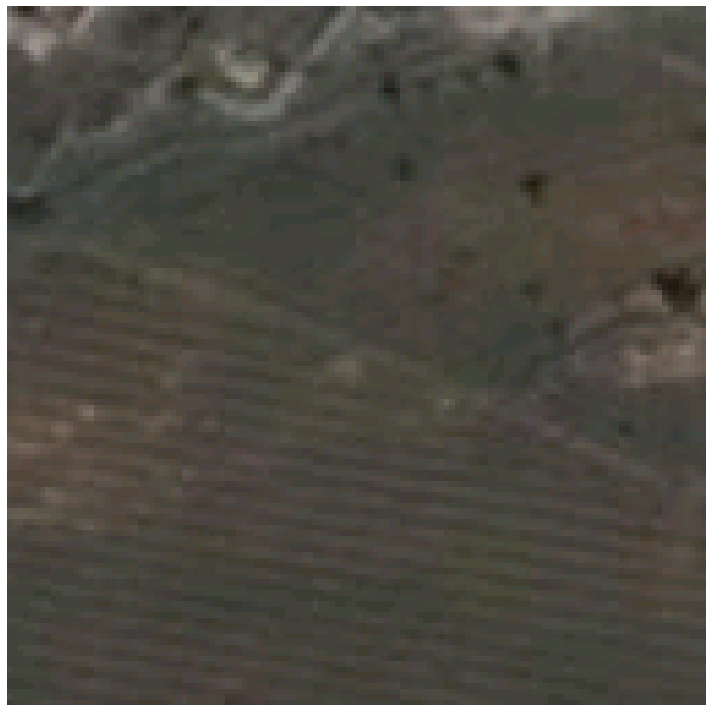

In [89]:
display(train_images[0].astype('int'))

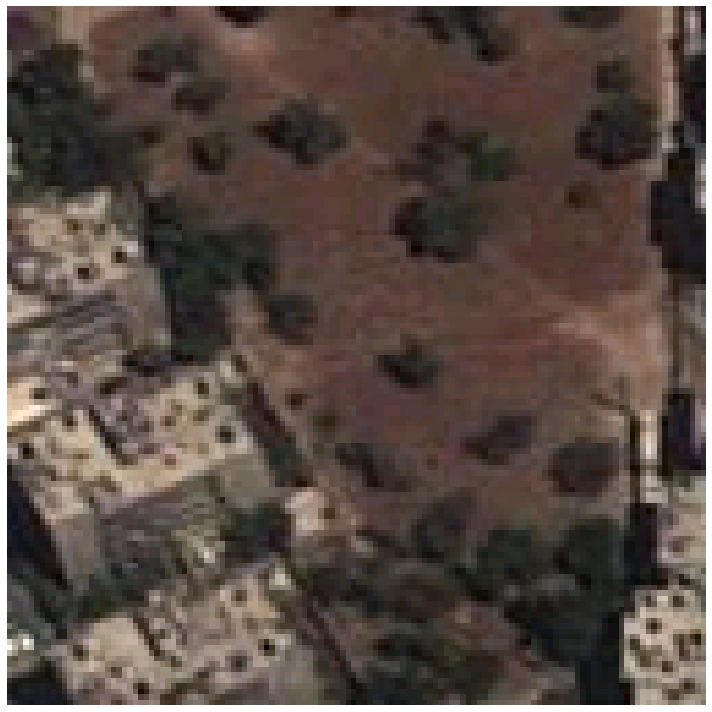

In [104]:
display(train_images_t0[43].astype('int'))

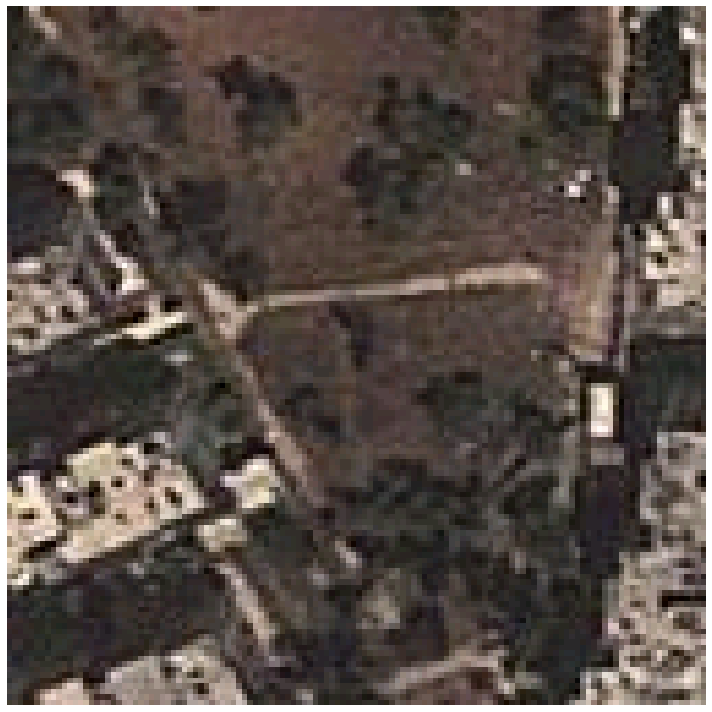

In [105]:
display(train_images_tt[43].astype('int'))